In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy.signal
import sys

In [12]:
video = cv2.VideoCapture('/content/drive/MyDrive/everglow/cohface/1/1/data.avi')

fps = video.get(cv2.CAP_PROP_FPS)

# 비디오의 너비와 높이 가져오기
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

print('FPS:', fps)
print('Resolution: {}x{}'.format(width, height))

# 비디오 객체 해제
video.release()

FPS: 20.0
Resolution: 640x480


In [3]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 30.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

## Make dataset

랜드마크를 통해 비디오를 자르고 3D-CNN의 64x64픽셀

In [20]:
import os
import numpy as np
import h5py
import cv2
from pathlib import Path

sys.path.append('/content/drive/MyDrive/everglow')
import utils  # 가정: utils 모듈에 필요한 함수가 정의되어 있음

def process_video_and_hdf5(video_path, hdf5_path):
    """비디오와 HDF5 데이터를 처리하여 필요한 데이터를 추출하고 반환"""
    # 비디오에서 랜드마크 추출
    print(video_path)
    lmrks = utils.mediapipe_landmark_video(video_path)
    output_video, successful = utils.make_video_array(video_path, lmrks)

    # HDF5에서 맥박 데이터 로드
    with h5py.File(hdf5_path, 'r') as file:
        pulse = file['pulse'][:]
        respiration = file['respiration'][:]
        time = file['time'][:]

    return output_video, lmrks, pulse, respiration, time, successful

def main(input_root, output_root):
    if not os.path.exists(output_root):
      os.makedirs(output_root)

    for session in range(1, 41):  # 세션 폴더 1에서 40까지
        for sub_session in range(4):  # 하위 세션 폴더 0에서 3까지
            session_folder = os.path.join(input_root, str(session), str(sub_session))
            video_path = os.path.join(session_folder, 'data.avi')
            hdf5_path = os.path.join(session_folder, 'data.hdf5')
            output_path = os.path.join(output_root, f'{session}_{sub_session}.npz')

            if os.path.exists(video_path) and os.path.exists(hdf5_path):
                video, lmrks, pulse, respiration, time, successful = process_video_and_hdf5(video_path, hdf5_path)
                if successful:
                    np.savez_compressed(output_path, video=video, pulse=pulse, respiration=respiration, video_path=str(video_path), fps=fps)
                    print(f'Successfully processed and saved: {output_path}')

# 경로 설정
input_root = '/content/drive/MyDrive/everglow/cohface/'  # COHFACE 데이터셋의 원본 경로
output_root = '/content/drive/MyDrive/everglow/cohface-npz/'  # 전처리된 데이터셋이 저장될 경로

main(input_root, output_root)


/content/drive/MyDrive/everglow/cohface/1/0/data.avi
Successfully processed and saved: /content/drive/MyDrive/everglow/cohface-npz/1_0.npz
/content/drive/MyDrive/everglow/cohface/1/1/data.avi
Successfully processed and saved: /content/drive/MyDrive/everglow/cohface-npz/1_1.npz
/content/drive/MyDrive/everglow/cohface/1/2/data.avi
Successfully processed and saved: /content/drive/MyDrive/everglow/cohface-npz/1_2.npz
/content/drive/MyDrive/everglow/cohface/1/3/data.avi
Successfully processed and saved: /content/drive/MyDrive/everglow/cohface-npz/1_3.npz
/content/drive/MyDrive/everglow/cohface/2/0/data.avi
Successfully processed and saved: /content/drive/MyDrive/everglow/cohface-npz/2_0.npz
/content/drive/MyDrive/everglow/cohface/2/1/data.avi
Successfully processed and saved: /content/drive/MyDrive/everglow/cohface-npz/2_1.npz
/content/drive/MyDrive/everglow/cohface/2/2/data.avi
Successfully processed and saved: /content/drive/MyDrive/everglow/cohface-npz/2_2.npz
/content/drive/MyDrive/ever

In [23]:
npz_file_path = '/content/drive/MyDrive/everglow/cohface-npz/17_0.npz'

data = np.load(npz_file_path)

keys = data.files
print("Keys in the npz file:", keys)

for key in keys:
    print(f"Shape of the data associated with key '{key}':", data[key].shape)

Keys in the npz file: ['video', 'pulse', 'respiration', 'video_path', 'fps']
Shape of the data associated with key 'video': (1226, 64, 64, 3)
Shape of the data associated with key 'pulse': (15712,)
Shape of the data associated with key 'respiration': (15712,)
Shape of the data associated with key 'video_path': ()
Shape of the data associated with key 'fps': ()


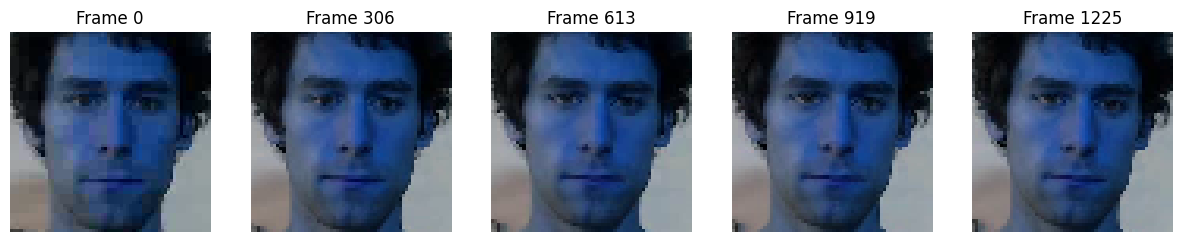

In [24]:
video = data['video']

num_frames, height, width, channels = video.shape

# 시각화할 프레임의 인덱스 선택
frame_indices = [0, num_frames // 4, num_frames // 2, 3 * num_frames // 4, num_frames - 1]

# 선택된 프레임 시각화
fig, axes = plt.subplots(1, len(frame_indices), figsize=(15, 5))
for ax, frame_idx in zip(axes, frame_indices):
    ax.imshow(video[frame_idx])
    ax.set_title(f'Frame {frame_idx}')
    ax.axis('off')
plt.show()

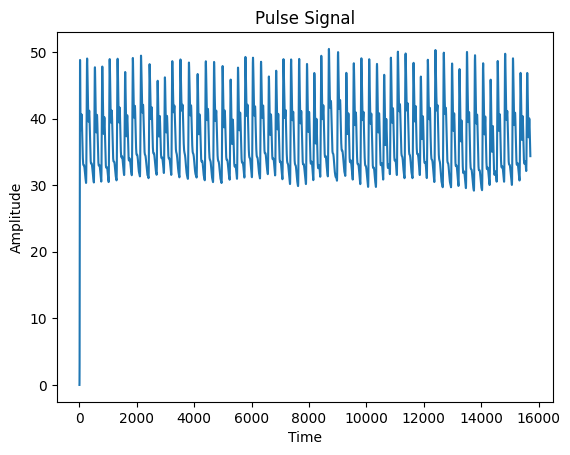

In [25]:
# 맥박 데이터 시각화
wave = data['pulse']

plt.plot(wave)
plt.title('Pulse Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## Make metadata

In [28]:
def main(input_root, output_path):
    subjects = natsorted(os.listdir(input_root))
    ids = []
    paths = []
    for subject in subjects:
        # 'subject' 문자열 뒤의 숫자(ID)를 추출합니다.
        subject_id = int(''.join(filter(str.isdigit, subject)))
        print(subject, subject_id)
        subject_path = os.path.join(input_root, subject)
        subject_path = os.path.abspath(subject_path)
        paths.append(subject_path)
        ids.append(subject_id)

    d = {}
    d['id'] = ids
    d['path'] = paths

    df = pd.DataFrame(d)
    df.to_csv(output_path, index=False)
    print(df)

# 입력 및 출력 경로 직접 설정
input_root = '/content/drive/MyDrive/everglow/cohface-npz/'
output_path = '/content/drive/MyDrive/everglow/cohface-npz/metadata_cohface.csv'

main(input_root, output_path)


1_0.npz 10
1_1.npz 11
1_2.npz 12
1_3.npz 13
2_0.npz 20
2_1.npz 21
2_2.npz 22
2_3.npz 23
3_0.npz 30
3_1.npz 31
3_2.npz 32
3_3.npz 33
4_0.npz 40
4_1.npz 41
4_2.npz 42
4_3.npz 43
5_0.npz 50
5_1.npz 51
5_2.npz 52
5_3.npz 53
6_0.npz 60
6_1.npz 61
6_2.npz 62
6_3.npz 63
7_0.npz 70
7_1.npz 71
7_2.npz 72
7_3.npz 73
8_0.npz 80
8_1.npz 81
8_2.npz 82
8_3.npz 83
9_0.npz 90
9_1.npz 91
9_2.npz 92
9_3.npz 93
10_0.npz 100
10_1.npz 101
10_2.npz 102
10_3.npz 103
11_0.npz 110
11_1.npz 111
11_2.npz 112
11_3.npz 113
12_0.npz 120
12_1.npz 121
12_2.npz 122
12_3.npz 123
13_0.npz 130
13_1.npz 131
13_2.npz 132
13_3.npz 133
14_0.npz 140
14_1.npz 141
14_2.npz 142
14_3.npz 143
15_0.npz 150
15_1.npz 151
15_2.npz 152
15_3.npz 153
16_0.npz 160
16_1.npz 161
16_2.npz 162
16_3.npz 163
17_0.npz 170
17_1.npz 171
17_2.npz 172
17_3.npz 173
18_0.npz 180
18_1.npz 181
18_2.npz 182
18_3.npz 183
19_0.npz 190
19_1.npz 191
19_2.npz 192
19_3.npz 193
20_0.npz 200
20_1.npz 201
20_2.npz 202
20_3.npz 203
21_0.npz 210
21_1.npz 211
21_2.n

In [29]:
df = pd.read_csv('/content/drive/MyDrive/everglow/cohface-npz/metadata_cohface.csv')
df

,id,path
0,10,/content/drive/MyDrive/everglow/cohface-npz/1_...
1,11,/content/drive/MyDrive/everglow/cohface-npz/1_...
2,12,/content/drive/MyDrive/everglow/cohface-npz/1_...
3,13,/content/drive/MyDrive/everglow/cohface-npz/1_...
4,20,/content/drive/MyDrive/everglow/cohface-npz/2_...
...,...,...
155,393,/content/drive/MyDrive/everglow/cohface-npz/39...
156,400,/content/drive/MyDrive/everglow/cohface-npz/40...
157,401,/content/drive/MyDrive/everglow/cohface-npz/40...
158,402,/content/drive/MyDrive/everglow/cohface-npz/40...
